In [1]:
import joblib

In [2]:
import json

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [6]:
from pathlib import Path

In [45]:
import shap

In [48]:
from sklearn.model_selection import train_test_split

In [78]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve

In [82]:
import matplotlib.pyplot as plt

In [46]:
shap.initjs()

In [10]:
PROJECT_ROOT = Path (
    r"C:/Users/user/Desktop/30-days-data-scientist-challenge"
)

In [11]:
DAY12_DIR = PROJECT_ROOT / 'day12_live_ml_project'

In [14]:
DAY13_DIR = PROJECT_ROOT / 'day13_day12model_continued'

In [15]:
MODEL_PATH = DAY12_DIR / 'model' / 'model.joblib'

In [16]:
META_PATH = DAY12_DIR / 'model' / 'model_meta.json'

In [17]:
DATA_PATH = DAY12_DIR / 'data' / 'credit_risk_dataset.csv'

In [18]:
MODEL_PATH, META_PATH, DATA_PATH

(WindowsPath('C:/Users/user/Desktop/30-days-data-scientist-challenge/day12_live_ml_project/model/model.joblib'),
 WindowsPath('C:/Users/user/Desktop/30-days-data-scientist-challenge/day12_live_ml_project/model/model_meta.json'),
 WindowsPath('C:/Users/user/Desktop/30-days-data-scientist-challenge/day12_live_ml_project/data/credit_risk_dataset.csv'))

In [19]:
pipe = joblib.load(MODEL_PATH)

In [20]:
with open(META_PATH, 'r', encoding = 'utf-8') as f:
    meta = json.load(f)

In [21]:
df = pd.read_csv(DATA_PATH)

In [22]:
target_col = meta["target_col"]

In [24]:
X = df.drop(columns = [target_col])

In [25]:
y = df[target_col]

#### Eğitilmiş pipeline'ı yeniden üretilebilir şekilde yüklemek,
#### Training ve inference ortamını ayırmak.

In [26]:
preprocess = pipe.named_steps['preprocess']

In [27]:
clf = pipe.named_steps['clf']

In [28]:
num_features = meta['num_cols']

In [29]:
cat_encoder = preprocess.named_transformers_['cat'].named_steps['onehot']

In [30]:
cat_features = cat_encoder.get_feature_names_out(meta['cat_cols'])

In [31]:
feature_names = np.concatenate([num_features,cat_features])

In [32]:
coefs = clf.coef_[0]

In [33]:
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', ascending = False)

In [34]:
coef_df.head(10)

,feature,coefficient
23,loan_grade_G,2.715473
5,loan_percent_income,1.366181
22,loan_grade_F,1.250589
10,person_home_ownership_RENT,0.923931
21,loan_grade_E,0.849330
13,loan_intent_HOMEIMPROVEMENT,0.603529
20,loan_grade_D,0.558787
8,person_home_ownership_OTHER,0.373693
11,loan_intent_DEBTCONSOLIDATION,0.349497
14,loan_intent_MEDICAL,0.267422


In [35]:
coef_df.tail(10)

,feature,coefficient
2,person_emp_length,-0.001928
0,person_age,-0.018022
15,loan_intent_PERSONAL,-0.048980
12,loan_intent_EDUCATION,-0.266007
3,loan_amnt,-0.649697
16,loan_intent_VENTURE,-0.689999
9,person_home_ownership_OWN,-1.336229
19,loan_grade_C,-1.494309
18,loan_grade_B,-1.696056
17,loan_grade_A,-1.968352


#### Pozitif coef -> default riskini arttırır
#### Negatif coef -> riski azaltır
#### Bu model doğrusal ve açılanabilir

In [38]:
X_transformed = preprocess.transform(X)

In [39]:
explainer = shap.LinearExplainer(
    clf,
    X_transformed,
    feature_names = feature_names
)

In [40]:
shap_values = explainer.shap_values(X_transformed)

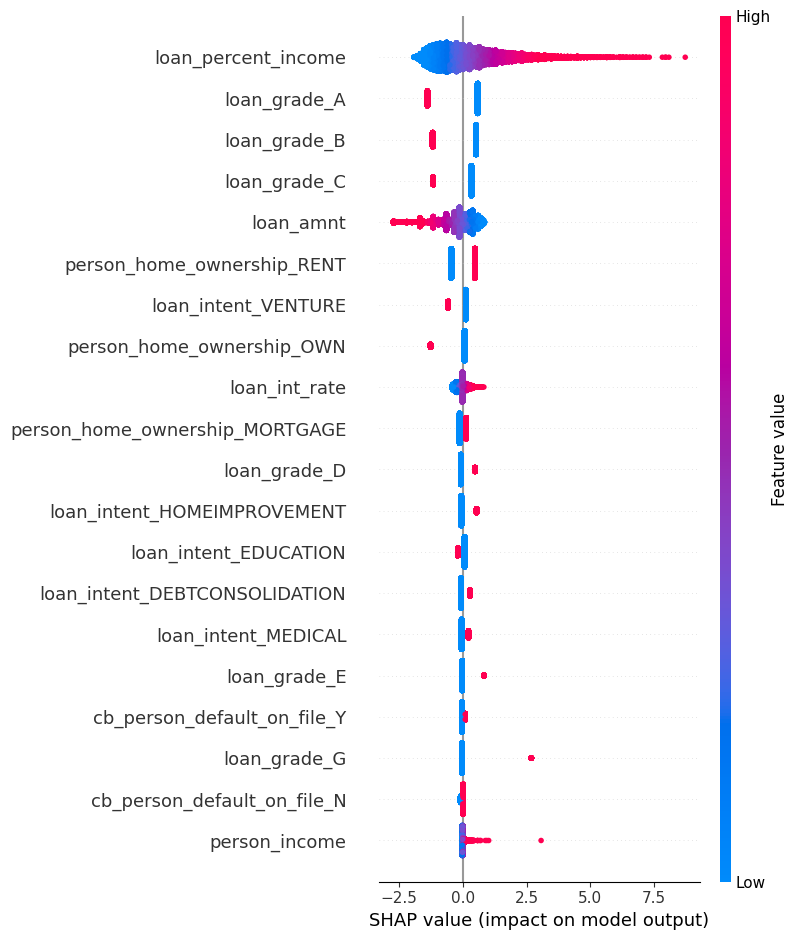

In [41]:
shap.summary_plot(shap_values, X_transformed, feature_names = feature_names)

###### Bu grafik modelin genel olarak hangi feature'lara daha fazla ağırlık verdiğini gösterir

In [42]:
i = 0

In [47]:
shap.force_plot (
    explainer.expected_value,
    shap_values[i],
    X_transformed[i],
    feature_names = feature_names
)

### Error Analysis Başlangıcı ###

In [51]:
def make_binary_target(y: pd.Series) -> pd.Series:
    if y.dtype.kind in 'biufc':
        uniq = pd.unique(y.dropna())
        if set(uniq).issubset({0,1}):
            return y.astype(int)
        return(pd.to_numeric(y,errors = 'coerce') > 0).astype(int)
    y_str = y.astype(str).str.lower().str.strip()
    positive_tokens = {'1','yes','true','default','bad','risk','high', 'charged off'}
    negative_tokens = {'0','no','false','non-default', 'good', 'low','paid','fully paid'}

    def to_bin(val: str) -> int:
        if any(tok in val for tok in positive_tokens): return 1
        if any(tok in val for tok in negative_tokens): return 0
        return 0
    return y.str.map(to_bin).astype(int)
    

In [52]:
y_bin = make_binary_target(y)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_bin, test_size = 0.2, random_state = 42, stratify = y_bin
)

In [56]:
proba_test = pipe.predict_proba(X_test)[:,1]

In [57]:
pred_test = (proba_test >= 0.5).astype(int)

In [58]:
cm = confusion_matrix(y_test,pred_test)

In [59]:
print('Confusion Matrix:\n', cm)

Confusion Matrix:
 [[4195  900]
 [ 313 1109]]


In [60]:
print("\nClassification Report:\n", classification_report(y_test, pred_test, digits = 4))


Classification Report:
               precision    recall  f1-score   support

           0     0.9306    0.8234    0.8737      5095
           1     0.5520    0.7799    0.6465      1422

    accuracy                         0.8139      6517
   macro avg     0.7413    0.8016    0.7601      6517
weighted avg     0.8480    0.8139    0.8241      6517



###### FP (False Positive): Aslında risksiz müşteriye “riskli” dedik → müşteri kaybı / gereksiz red

###### FN (False Negative): Aslında riskli müşteriye “risksiz” dedik → kredi batığı / finansal zarar

In [61]:
errors = X_test.copy()

In [62]:
errors['y_true'] = y_test.values

In [63]:
errors['y_pred'] = pred_test

In [64]:
errors['prob'] = proba_test

In [65]:
false_pos = errors[(errors.y_true == 0) & (errors.y_pred == 1)]

In [67]:
false_neg =  errors[(errors.y_true == 1) & (errors.y_pred == 0)]

In [68]:
false_pos.shape, false_neg.shape

((900, 14), (313, 14))

In [69]:
num_cols = meta['num_cols']

In [70]:
fp_stats = false_pos[num_cols].describe().T[['mean', '50%', 'std']].rename(columns = {'50%':'median'})

In [71]:
fn_stats = false_neg[num_cols].describe().T[['mean', '50%','std']].rename(columns = {'50%':'median'})

In [72]:
fp_stats.head(), fn_stats.head()

(                           mean    median           std
 person_age            28.214444     26.00      6.526374
 person_income      50169.215556  43914.00  25919.841867
 person_emp_length      4.694761      4.00      3.954444
 loan_amnt          11106.583333  10000.00   5908.378049
 loan_int_rate         12.949466     13.24      2.946975,
                            mean    median           std
 person_age            27.763578     26.00      6.285541
 person_income      59838.920128  49963.00  44423.860272
 person_emp_length      5.077181      4.00      4.220052
 loan_amnt           8027.236422   5775.00   6854.261772
 loan_int_rate         10.827789     10.74      2.737044)

In [73]:
test_stats = X_test[num_cols].describe().T[['mean', '50%', 'std']].rename(columns = {'50%': 'median'})

In [74]:
compare = test_stats.join(
    fp_stats.add_prefix('FP_')
).join(
    fn_stats.add_prefix("FN_")
)

In [75]:
compare.sort_values("FN_mean", ascending = False).head(15)

,mean,median,std,FP_mean,FP_median,FP_std,FN_mean,FN_median,FN_std
person_income,66200.230167,55000.00,54508.957708,50169.215556,43914.00,25919.841867,59838.920128,49963.00,44423.860272
loan_amnt,9670.385147,8000.00,6425.478279,11106.583333,10000.00,5908.378049,8027.236422,5775.00,6854.261772
person_age,27.862053,26.00,6.429470,28.214444,26.00,6.526374,27.763578,26.00,6.285541
loan_int_rate,10.995983,10.99,3.261444,12.949466,13.24,2.946975,10.827789,10.74,2.737044
cb_person_cred_hist_length,5.874482,4.00,4.134393,6.136667,4.00,4.180599,5.824281,4.00,4.103366
person_emp_length,4.770126,4.00,4.021876,4.694761,4.00,3.954444,5.077181,4.00,4.220052
loan_percent_income,0.170302,0.15,0.106687,0.235700,0.23,0.095189,0.141182,0.12,0.082847


In [76]:
cat_cols = meta['cat_cols']

In [77]:
for c in cat_cols[:5]:
    print("\n###",c)
    print("FP top:", false_pos[c].astype(str).value_counts().head(5))
    print("FN top:", false_neg[c].astype(str).value_counts().head(5))


### person_home_ownership
FP top: person_home_ownership
RENT        557
MORTGAGE    299
OWN          40
OTHER         4
Name: count, dtype: int64
FN top: person_home_ownership
MORTGAGE    156
RENT        134
OWN          22
OTHER         1
Name: count, dtype: int64

### loan_intent
FP top: loan_intent
MEDICAL              189
PERSONAL             173
EDUCATION            167
DEBTCONSOLIDATION    149
HOMEIMPROVEMENT      133
Name: count, dtype: int64
FN top: loan_intent
MEDICAL              61
EDUCATION            60
PERSONAL             58
DEBTCONSOLIDATION    54
HOMEIMPROVEMENT      45
Name: count, dtype: int64

### loan_grade
FP top: loan_grade
B    268
D    246
C    199
A    108
E     64
Name: count, dtype: int64
FN top: loan_grade
B    102
C    101
A    100
D      8
E      2
Name: count, dtype: int64

### cb_person_default_on_file
FP top: cb_person_default_on_file
N    642
Y    258
Name: count, dtype: int64
FN top: cb_person_default_on_file
N    262
Y     51
Name: count, dtype: in

In [79]:
prec, rec, thr = precision_recall_curve(y_test, proba_test)

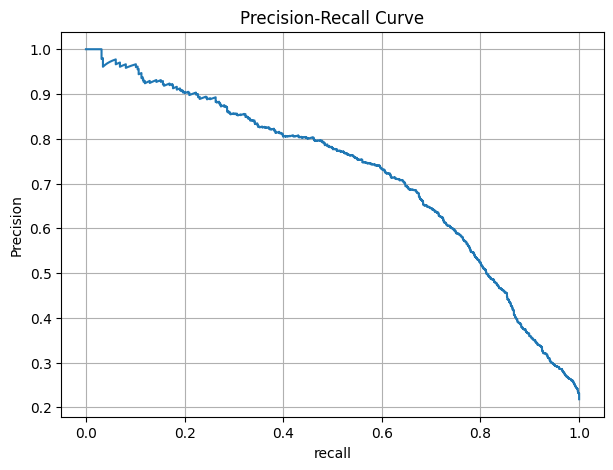

In [84]:
plt.figure(figsize=(7,5))
plt.plot(rec,prec)
plt.xlabel('recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

###### Bu eğri, farklı threshold değerlerinde precision–recall dengesini gösterir.

In [86]:
pr_df = pd.DataFrame({
    'threshold': thr,
    'precision' : prec[:-1],
    'recall': rec[:-1]
})

In [87]:
pr_df.head()

,threshold,precision,recall
0,0.001356,0.218199,1.0
1,0.004704,0.218232,1.0
2,0.005304,0.218266,1.0
3,0.005313,0.218299,1.0
4,0.005395,0.218333,1.0


In [89]:
pr_df.sort_values('recall', ascending = False).head(5)

,threshold,precision,recall
0,0.001356,0.218199,1.0
1,0.004704,0.218232,1.0
2,0.005304,0.218266,1.0
3,0.005313,0.218299,1.0
4,0.005395,0.218333,1.0


###### Düşük threshold → yüksek recall → daha fazla risk yakalanır
###### Ama precision düşer (daha çok yanlış alarm)

In [90]:
pr_df.sort_values('precision', ascending = False).head(5)

,threshold,precision,recall
6485,0.996340,1.0,0.015471
6486,0.996486,1.0,0.014768
6506,0.999324,1.0,0.000703
6505,0.999304,1.0,0.001406
6504,0.999190,1.0,0.002110


###### Yüksek threshold → daha az yanlış alarm
###### Ama bazı riskli müşteriler kaçabilir

In [92]:
pr_df['f1'] = 2 * (pr_df.precision * pr_df.recall) / (pr_df.precision + pr_df.recall)

In [93]:
pr_df.sort_values('f1', ascending = False).head(5)

,threshold,precision,recall,f1
5119,0.672781,0.685159,0.668776,0.676868
5121,0.673326,0.685426,0.668073,0.676638
5118,0.672505,0.684665,0.668776,0.676628
5115,0.671804,0.683908,0.669480,0.676617
5097,0.667889,0.679433,0.673699,0.676554


###### F1 maksimum olan threshold, precision ve recall arasında denge sağlar.

In [95]:
best_thr = pr_df.sort_values('f1', ascending = False).iloc[0]['threshold']

In [97]:
best_thr

np.float64(0.6727811860536768)

In [98]:
pred_best = (proba_test >= best_thr).astype(int)

In [99]:
confusion_matrix(y_test, pred_best)

array([[4658,  437],
       [ 471,  951]])

###### Default threshold (0.5) yerine business-driven threshold seçildi.

#### “In this credit risk use case, false negatives are more costly than false positives. Therefore, the decision threshold was adjusted to prioritize recall over precision. This reduces the chance of approving risky customers at the expense of rejecting some low-risk ones.”

In [101]:
print('Default threshold = 0.5\n')
print (classification_report(y_test, pred_best, digits = 4))

Default threshold = 0.5

              precision    recall  f1-score   support

           0     0.9082    0.9142    0.9112      5095
           1     0.6852    0.6688    0.6769      1422

    accuracy                         0.8607      6517
   macro avg     0.7967    0.7915    0.7940      6517
weighted avg     0.8595    0.8607    0.8601      6517



In [102]:
print("\nCustom threshold = ", round(best_thr,3), '\n')
print(classification_report(y_test, pred_best, digits = 4 ))


Custom threshold =  0.673 

              precision    recall  f1-score   support

           0     0.9082    0.9142    0.9112      5095
           1     0.6852    0.6688    0.6769      1422

    accuracy                         0.8607      6517
   macro avg     0.7967    0.7915    0.7940      6517
weighted avg     0.8595    0.8607    0.8601      6517

